In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)


In [3]:
df = pd.read_csv("../ev_data.csv")  
df.head()


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJSA1E65N,Yakima,Granger,WA,98932.0,2022,TESLA,MODEL S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,187279214,POINT (-120.1871 46.33949),PACIFICORP,5.307700e+10
1,KNDC3DLC5N,Yakima,Yakima,WA,98902.0,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,210098241,POINT (-120.52041 46.59751),PACIFICORP,5.307700e+10
2,5YJYGDEEXL,Snohomish,Everett,WA,98208.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,44.0,121781950,POINT (-122.18637 47.89251),PUGET SOUND ENERGY INC,5.306104e+10
3,3C3CFFGE1G,Yakima,Yakima,WA,98908.0,2016,FIAT,500,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,14.0,180778377,POINT (-120.60199 46.59817),PACIFICORP,5.307700e+10
4,KNDCC3LD5K,Kitsap,Bremerton,WA,98312.0,2019,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26.0,0.0,26.0,2581225,POINT (-122.65223 47.57192),PUGET SOUND ENERGY INC,5.303508e+10


In [4]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())


Shape: (250659, 17)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250659 entries, 0 to 250658
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         250659 non-null  object 
 1   County                                             250653 non-null  object 
 2   City                                               250653 non-null  object 
 3   State                                              250659 non-null  object 
 4   Postal Code                                        250653 non-null  float64
 5   Model Year                                         250659 non-null  int64  
 6   Make                                               250659 non-null  object 
 7   Model                                              250659 non-null  object 
 8   Electric Vehicle Type                          

In [5]:
df_clean = df.drop(columns=[
    "VIN (1-10)", "Postal Code", "DOL Vehicle ID", 
    "Vehicle Location", "2020 Census Tract"
])

df_clean.head()


,County,City,State,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,Electric Utility
0,Yakima,Granger,WA,2022,TESLA,MODEL S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,PACIFICORP
1,Yakima,Yakima,WA,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,PACIFICORP
2,Snohomish,Everett,WA,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,44.0,PUGET SOUND ENERGY INC
3,Yakima,Yakima,WA,2016,FIAT,500,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,14.0,PACIFICORP
4,Kitsap,Bremerton,WA,2019,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26.0,0.0,26.0,PUGET SOUND ENERGY INC


In [6]:
df_clean = df_clean.drop_duplicates()

for col in df_clean.columns:
    if df_clean[col].dtype == "object":
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    else:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print("Missing values after cleaning:")
print(df_clean.isnull().sum())


Missing values after cleaning:
County                                               0
City                                                 0
State                                                0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
Electric Utility                                     0
dtype: int64


In [7]:
cat_cols = df_clean.select_dtypes(include=["object"]).columns
print("Categorical columns:", cat_cols)

df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

df_encoded.head()


Categorical columns: Index(['County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
       'Electric Utility'],
      dtype='object')


,Model Year,Electric Range,Base MSRP,Legislative District,County_Adams,County_Alameda,County_Albemarle,County_Alexandria,County_Allegheny,County_Allen,...,Electric Utility_PORTLAND GENERAL ELECTRIC CO,Electric Utility_PUD NO 1 OF CHELAN COUNTY,Electric Utility_PUD NO 1 OF DOUGLAS COUNTY,Electric Utility_PUD NO 1 OF OKANOGAN COUNTY,Electric Utility_PUD NO 1 OF PEND OREILLE COUNTY,Electric Utility_PUD NO 1 OF WHATCOM COUNTY,Electric Utility_PUD NO 2 OF GRANT COUNTY,Electric Utility_PUGET SOUND ENERGY INC,Electric Utility_PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),Electric Utility_PUGET SOUND ENERGY INC||PUD NO 1 OF WHATCOM COUNTY
0,2022,0.0,0.0,15.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2022,0.0,0.0,15.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2020,291.0,0.0,44.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2016,84.0,0.0,14.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2019,26.0,0.0,26.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [10]:
print("Summary statistics (numeric features):")
print(df.describe())

numeric_df = df.select_dtypes(include=["number"])
print("\nCorrelation matrix:")
print(numeric_df.corr())



Summary statistics (numeric features):
         Postal Code     Model Year  Electric Range      Base MSRP  \
count  250653.000000  250659.000000   250638.000000  250638.000000   
mean    98176.796089    2021.628252       44.073002     727.403107   
std      2555.064640       3.021254       82.412875    6917.315299   
min      1731.000000    2000.000000        0.000000       0.000000   
25%     98052.000000    2020.000000        0.000000       0.000000   
50%     98126.000000    2023.000000        0.000000       0.000000   
75%     98382.000000    2024.000000       37.000000       0.000000   
max     99577.000000    2026.000000      337.000000  845000.000000   

       Legislative District  DOL Vehicle ID  2020 Census Tract  
count         250076.000000    2.506590e+05       2.506530e+05  
mean              28.994994    2.392132e+08       5.297386e+10  
std               14.862288    6.671019e+07       1.618543e+09  
min                1.000000    4.385000e+03       1.001020e+09  
25%  

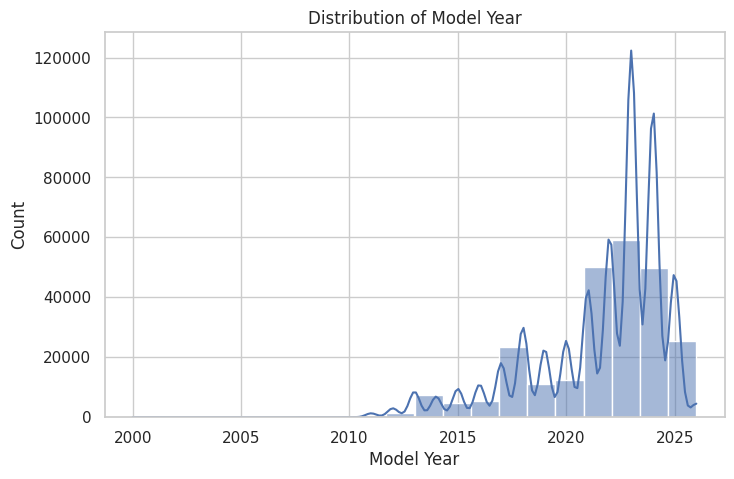

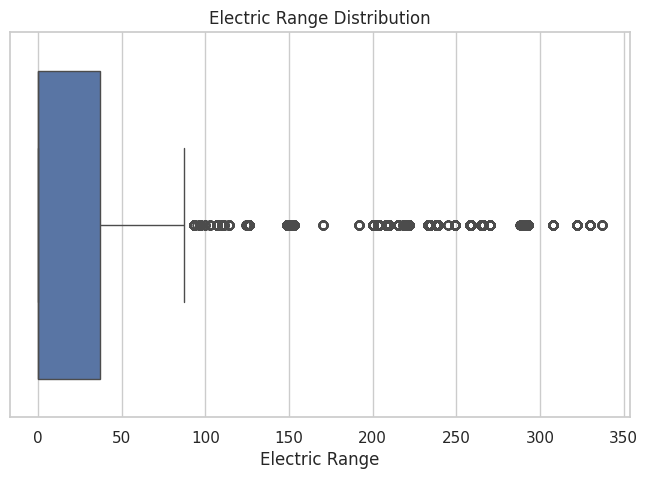

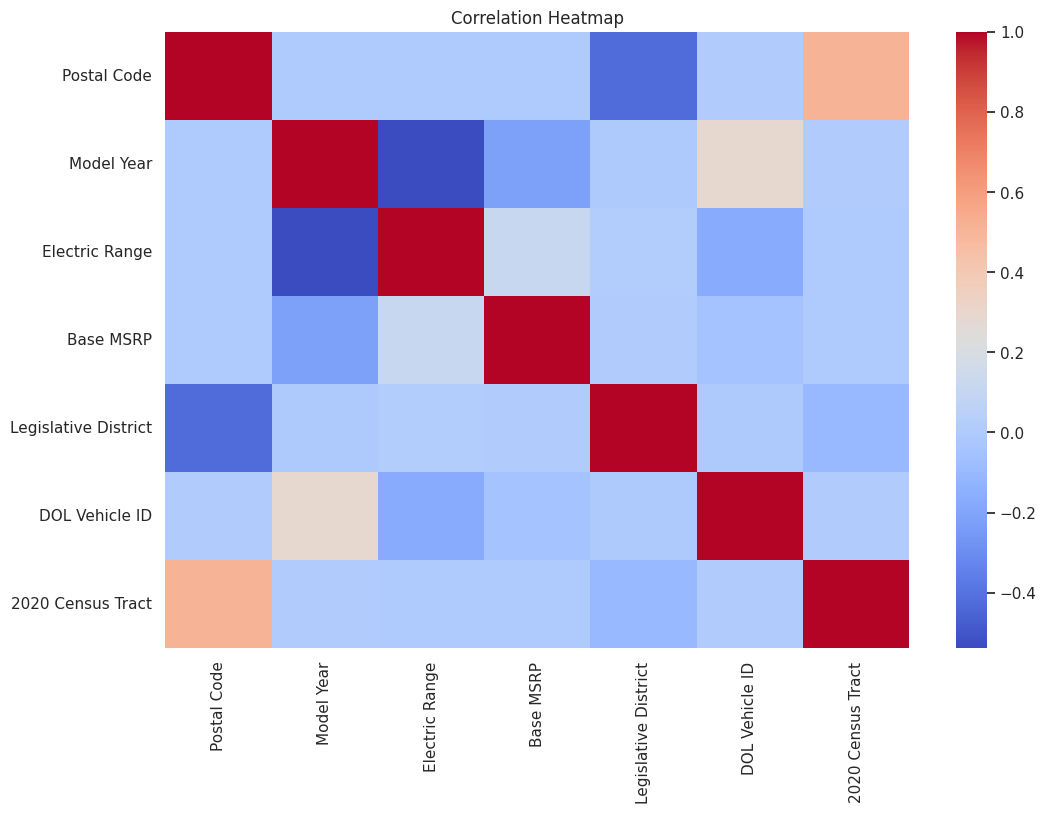

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(df["Model Year"], bins=20, kde=True)
plt.title("Distribution of Model Year")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Electric Range"])
plt.title("Electric Range Distribution")
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [12]:
fig = px.scatter(df, x="Model Year", y="Electric Range", 
                 title="Electric Range vs Model Year (Interactive)")
fig.show()


In [20]:
df["EV_Type_Label"] = df["Electric Vehicle Type"].map({
    "Battery Electric Vehicle (BEV)": 0,
    "Plug-in Hybrid Electric Vehicle (PHEV)": 1
})

y = df["EV_Type_Label"]
X = df.drop(columns=["Electric Vehicle Type", "EV_Type_Label"])


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (200527, 16)
Test shape: (50132, 16)


In [ ]:
df["EV_Type_Label"] = df["Electric Vehicle Type"].map({
    "Battery Electric Vehicle (BEV)": 0,
    "Plug-in Hybrid Electric Vehicle (PHEV)": 1
})

y = df["EV_Type_Label"]

X = df.select_dtypes(include=["number"]).drop(columns=["EV_Type_Label"])

print("Features in X:", X.columns.tolist())
print("Shape of X:", X.shape)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape after scaling:", X_train.shape)


Features in X: ['Postal Code', 'Model Year', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', '2020 Census Tract']
Shape of X: (250659, 7)
X_train shape after scaling: (200527, 7)


In [30]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

knn.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

knn_pred = knn.predict(X_test)
dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)

print("Baseline Accuracy Scores:")
print("KNN:", accuracy_score(y_test, knn_pred))
print("Decision Tree:", accuracy_score(y_test, dt_pred))
print("Random Forest:", accuracy_score(y_test, rf_pred))


Baseline Accuracy Scores:
KNN: 0.993816324902258
Decision Tree: 0.9999002633048751
Random Forest: 0.9998404212878003


In [ ]:
import pandas as pd

importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("Feature Importances (Random Forest):")
print(importance_df)


Feature Importances (Random Forest):
                Feature  Importance
2        Electric Range    0.828950
1            Model Year    0.128623
5        DOL Vehicle ID    0.022492
3             Base MSRP    0.007351
0           Postal Code    0.006710
6     2020 Census Tract    0.003655
4  Legislative District    0.002219


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "KNN": knn,
    "Decision Tree": dt,
    "Random Forest": rf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))



KNN Evaluation:
Accuracy: 0.993816324902258
Precision: 0.9910633597750779
Recall: 0.9780992964027351
F1 Score: 0.9845386533665835

Decision Tree Evaluation:
Accuracy: 0.9999002633048751
Precision: 0.9998017839444995
Recall: 0.9997027053810326
F1 Score: 0.9997522422080174

Random Forest Evaluation:
Accuracy: 0.9998404212878003
Precision: 0.9998017249925647
Recall: 0.9994054107620652
F1 Score: 0.9996035285955001


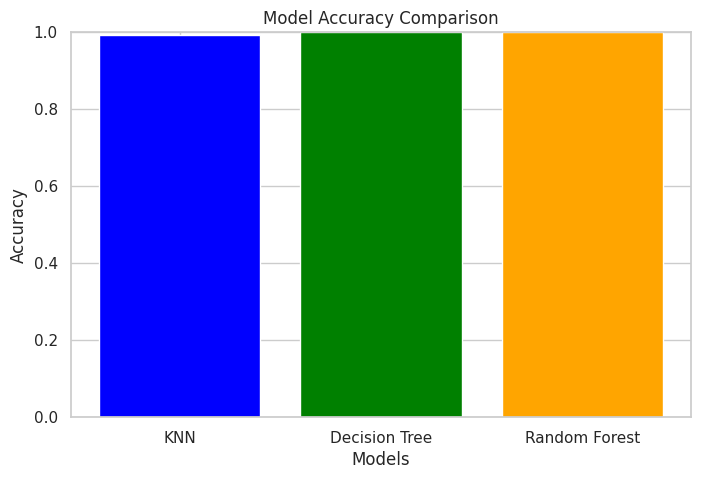

In [29]:
import matplotlib.pyplot as plt

model_names = []
accuracies = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_names.append(name)
    accuracies.append(acc)

plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.show()
